In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, argmax
import random
from scipy import misc, ndimage
from sklearn.metrics import accuracy_score
import h5py
import datetime
from keras.utils import to_categorical
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [ ]:
we will load?

In this Jupyter notebook regression CNN training process for number bounding box coordinates predictions is described. Also, we will look at our model results and basic error analysis. In the end of notebook tensorflow model converted into tflite model.


## 1) Load and prepare train and validate dataset

Firstly, we  load dataset and then prepare it for training like described [4__Object_detection_dataset.ipynb](4__Object_detection_dataset.ipynb) in Juyter notebook.

In [2]:
%%time

with h5py.File('D:/regression_1.hdf5', 'r') as f:
    validate_data = f["validate"][:]
    validate_labels = f["validate labels"][:]
    validate_coordinates = f["validate coordinates"][:]
    train_data = f["train"][:]
    train_labels = f["train labels"][:]
    train_coordinates = f["train coordinates"][:]
    train_length = f["train length"][:]
    test_data = f["test"][:]
    test_labels = f["test labels"][:]
    test_coordinates = f["test coordinates"][:]

Wall time: 2min 7s


Normalize images pixels coordinates from 
$$ x \in [0;64],  y\in [0;48] \rightarrow x,y\in[0,1] $$

In [3]:
train_coordinates[:,[0,2]] = train_coordinates[:,[0,2]]/ 48.0
train_coordinates[:,[1,3]] = train_coordinates[:,[1,3]]/ 64.0

validate_coordinates[:,[0,2]] = validate_coordinates[:,[0,2]]/ 48.0
validate_coordinates[:,[1,3]] = validate_coordinates[:,[1,3]]/ 64.0

## 2) Convolutional neural network (CNN) architecture

We use the same CNN B architecture (each head has own full connected layer) like we trained classifier model, just now add third head which will predicts number bounding box coordinates. New head has four variables - number bounding box width, height and box top-left vertexes coordinates in the images.

<img src="CNN_reg_architecture.png" title="CNN architectures">

## 3) Convolutional neural network (CNN) loss fucntions

Firstly we will train all CNN neural network except length full connected layer and it's head, for it we use two minimization loss functions:

$$loss1 = k * logitLoss + boxRMSE$$

$$loss2 =  logitLoss + \frac{boxIoU}{k}  $$

* $k$ is coefficient which initial value at first epoch is 10 and decaying exponentially every 5000 steps with a base of 0.98. <end>
* $logtiLoss$ here is sum of digits cross entropy with softmax loss.
* $boxRMSE$ here is sum of each box head variable RMSE loss.
* $boxIoU$ here Intersection over Union of each BOX head variable $i$ :
    $$ boxIoU = 1 - \sum_{i=1}^{n} \frac{IoU_i}{n}$$ 

$loss1$ function is used until 100 000 epoch for faster digits head and box head convergence, $loss2$ - for more accurate number bounding box variables predictions.


In [ ]:
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    
    yA = max(boxA[0], boxB[0])
    yB = min(boxA[1], boxB[1])
    xA = max(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])
    

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[1] - boxA[0]) * (boxA[3] - boxA[2])
    boxBArea = (boxB[1] - boxB[0]) * (boxB[3] - boxB[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / (float(boxAArea + boxBArea - interArea) +0.0001)

    # return the intersection over union value
    return iou

In [2]:
def tf_IoU(x1, x2):
    eps =  tf.constant(0.0001)
    #y11, y12, x11, x12 = tf.split(x1, 4, axis=1)
    #y21, y22, x21, x22 = tf.split(x2, 4, axis=1)
    y11, x11, h1, w1 = tf.split(x1, 4, axis=1)
    y21, x21, h2, w2 = tf.split(x2, 4, axis=1)


    xA = tf.maximum(x11, x21)
    yA = tf.maximum(y11, y21)
    #xB = tf.minimum(x12, x22)
    #yB = tf.minimum(y12, y22)
    xB = tf.minimum(x11 + w1, x21 + w2)
    yB = tf.minimum(y11 + h1, y21 + h2)

    interArea = tf.maximum((xB - xA), 0) * tf.maximum((yB - yA), 0)

    boxAArea = w1 * h1 #(x12 - x11) * (y12 - y11)  #w1 * h1
    boxBArea = w2 * h2 #(x22 - x21) * (y22 - y21) #w2 * h2#

    
    IoU = tf.reduce_mean(interArea / (boxAArea + boxBArea - interArea + eps))

    return IoU

def tf_acc(pred_label, actual_label):
    acc = tf.reduce_mean(tf.cast(tf.equal(pred_label, actual_label), tf.float32))
    return acc

def calculate_digit_acc(pred_label, label, i):
  digit_label = argmax(label[:,i,:], axis = 1)
  acc = accuracy_score(pred_label[i], digit_label)
  return acc

def calculate_digit_acc_tf(pred_label, label, i):
  digit_label = tf.argmax(label[:,i,:], axis = 1)
  acc = tf.reduce_mean(tf.cast(tf.equal(pred_label[i], digit_label), tf.float32))
  return acc

## 4) Convolutional neural network (CNN) training

Training configuration:

* AdamOptimizer optimizer with  $5x10^{-3}$  initial learning rate which decay exponentialy every 5000 steps with a base of 0.96.
* Dropouts set to 0.9
* 200 000 epochs for digits heads and 150 000 heads for length head (look above)



In [ ]:
def calculate_metrics(pred_labels, labels): 
    acc1 = calculate_digit_acc(pred_labels, labels, 0)
    acc2 = calculate_digit_acc(pred_labels, labels, 1)
    acc3 = calculate_digit_acc(pred_labels, labels, 2)
    acc = np.mean([acc1,acc2,acc3])
    
    return [acc1, acc2, acc3, acc] 
    

def write_summary(train, writer, step, acc, IoU, loss= [0,0], learning_rate = 0, loss_ratio = 0):
    
    summary = tf.Summary()
    summary.value.add(tag="d1_acc", simple_value= acc[0])
    summary.value.add(tag="d2_acc", simple_value= acc[1])
    summary.value.add(tag="d3_acc", simple_value= acc[2])
    summary.value.add(tag="acc", simple_value= acc[3])
    summary.value.add(tag="IoU", simple_value= IoU)
    if train:
        summary.value.add(tag="regression_loss", simple_value= loss[0])
        summary.value.add(tag="classifier_loss", simple_value= loss[1])
        summary.value.add(tag="learning_rate", simple_value= learning_rate)
        summary.value.add(tag="loss_ratio", simple_value= loss_ratio)
    writer.add_summary(summary, step)

def write_len_summary(train, writer, step, acc, loss= 0, learning_rate = 0):
    summary = tf.Summary()
    summary.value.add(tag="length acc", simple_value= acc[0])
    summary.value.add(tag="background acc", simple_value= acc[1])
    summary.value.add(tag="more than 3 acc", simple_value= acc[2])
    if train:
        summary.value.add(tag="length_loss", simple_value= loss)
        summary.value.add(tag="learning_rate", simple_value= learning_rate)
    writer.add_summary(summary, step)

def eval_val_data(step, val_batch_size, validate_writer, session):

    acc1 = []; acc2 = []; acc3 = []; val_pred = []
    IoU1 = []; IoU2 = []; IoU3 = []; val_IoU = []
    val_steps = len(validate_data)// val_batch_size
    
    for j in range(val_steps):

        val_offset = (j * val_batch_size) % (len(validate_data) - val_batch_size)
        val_batch_data = validate_data[val_offset:(val_offset + val_batch_size), :, :, :]
        val_batch_labels = validate_labels[val_offset:(val_offset + val_batch_size)]
        val_batch_coord = validate_coordinates[val_offset:(val_offset + val_batch_size)]
   
        feed_dict={tf_val_dataset: val_batch_data,
                   tf_val_labels: val_batch_labels, 
                   tf_val_box: val_batch_coord[:,:4], 
                  }
    
        val_batch_IoU, val_batch_pred = session.run( [validation_IoU,  validate_predictions], feed_dict=feed_dict)

        
        acc1.append(calculate_digit_acc(val_batch_pred, val_batch_labels, 0))
        acc2.append(calculate_digit_acc(val_batch_pred, val_batch_labels, 1))
        acc3.append(calculate_digit_acc(val_batch_pred, val_batch_labels, 2))  
        val_pred.append(np.mean([acc1,acc2,acc3]))
        val_IoU.append(val_batch_IoU)

    val_IoU = np.mean(val_IoU) 
    acc1 = np.mean(acc1); acc2 = np.mean(acc2);
    acc3 = np.mean(acc3); val_acc = np.mean(val_pred)
    
    write_summary(False, validate_writer, step, [acc1, acc2, acc3, val_acc],  val_IoU)
    print('D1: %.2f  D2: %.2f  D3: %.2f' % (acc1*100, acc2*100, acc3*100))
    print('Validate acc at step %d: (%.2f %.2f) ' % (step, val_acc*100, val_IoU*100))
    
    
def eval_length_valid_data(step, val_batch_size, validate_writer, session):
    acc = []; val_labels_1 = [];  val_labels_2 = []; val_pred_1 = []; val_pred_2 = []
    val_steps = len(validate_data)// val_batch_size
    for j in range(val_steps):
        
        val_offset = (j * val_batch_size) % (len(validate_data) - val_batch_size)
        val_batch_data = validate_data[val_offset:(val_offset + val_batch_size)]
        val_batch_labels = argmax(validate_labels[val_offset:(val_offset + val_batch_size)] , axis = 1)   
        
        val_batch_pred = np.array(validate_len_pred.eval(feed_dict={tf_val_dataset : val_batch_data}))
        acc.append(accuracy_score(val_batch_pred, val_batch_labels))
        ind1 = np.where(val_batch_labels == 0); ind2 = np.where(val_batch_labels == 4)
        val_labels_1.append(val_batch_labels[ind1]); val_labels_2.append(val_batch_labels[ind2])
        val_pred_1.append(val_batch_pred[ind1]); val_pred_2.append(val_batch_pred[ind2]);
        
    acc_background = accuracy_score(val_labels_1, val_pred_1)
    acc_more_than_3 = accuracy_score(val_labels_2, val_pred_2)
    val_acc = np.mean(acc)
    
    val_summary = tf.Summary()
    val_summary.value.add(tag="length acc", simple_value= val_acc)
    val_summary.value.add(tag="background acc", simple_value= val_acc_background)
    val_summary.value.add(tag="more than 3 acc", simple_value= val_acc_more)
    validate_writer.add_summary(val_summary, step)
    print('Validate acc at step %d: %.2f' % (step, val_acc*100)) 
    print('Background: %.2f,  More than 3: %.2f  ' % (acc_background*100, acc_more_than_3*100)) 
    


In [43]:
def train_model(num_start, num_end, batch_size, model_ind, model_path, new_model_path, loadModel=False, length_model = False):


    path_to_model_pb = os.path.join( "Models", "Model_reg" + model_ind)
    LOGDIR = "/temp/SVHN_reg/" + model_ind
    if length_model:
        LOGDIR = "/temp/SVHN_reg/"+model_ind+ "/len/"
   
    
    with tf.Session(graph=graph) as session:
        if loadModel:
            reader = tf.train.NewCheckpointReader(model_path)
            reader.get_variable_to_shape_map()
            saver.restore(session, model_path)
            print('Model restored.')
        else:
            tf.global_variables_initializer().run()
            print('Initialized.')

        train_writer = tf.summary.FileWriter(LOGDIR+"/train", session.graph)
        validate_writer = tf.summary.FileWriter(LOGDIR+"/val", session.graph)
        
        for step in range(num_start, num_end):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_data[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            if length_model:
                feed_dict = {tf_train_dataset: batch_data,
                     tf_train_length: batch_labels, 
                    }
                length_training(step, session, feed_dict, batch_labels, validate_writer, train_writer)
            else:
                batch_coord = train_coordinates[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels, 
                     tf_train_box: batch_coord[:,:4]
                    }
                regression_training(step, session, feed_dict, batch_labels, validate_writer, train_writer)                 

            if ((step % 2000 == 0) and (step is not 0)): 
                save_path = saver.save(session, new_model_path)
                print("Model saved.")
                
        train_writer.close()
        validate_writer.close()
        tf.train.write_graph(graph, path_to_model_pb,\
                         'Classification'+model_ind+'.pb', as_text=False)
        
def length_training(step, session, feed_dict, batch_labels, validate_writer, train_writer):
    
    if (step % 500 == 0) or (step % 200 == 0) or (step is 1):
        _, l, batch_pred, lr = \
            session.run([length_optimizer, length_loss, softmax_argmax(length), learning_rate], feed_dict=feed_dict) 
            
        if (step % 500 == 0):
            labels =  argmax(batch_labels, axis = 1)
            acc  = accuracy_score(batch_pred, labels)     
            ind1 = np.where(labels == 0); ind2 = np.where(labels == 4)  
            acc_background  = accuracy_score(batch_pred[ind1], labels[ind1])   
            acc_more_than_3  = accuracy_score(batch_pred[ind2], labels[ind2])   
            write_len_summary(True, train_writer, step, [acc, acc_background, acc_more_than_3], l, lr)
            
        elif (step % 200 == 0):
            print(datetime.datetime.now(),'| Minibatch loss at step %d: %f' % (step, l))
        
    if (step % 1000 == 0):
        eval_length_valid_data(step, 500, validate_writer, session)
    else:
        _ =  session.run([length_optimizer], feed_dict=feed_dict)
        
        
def regression_training(step, session, feed_dict, batch_labels, validate_writer, train_writer):
    
    if (step % 500 == 0) or (step % 200 == 0) or (step is 1):

        _, rl, cl, lr,  train_IoU, train_batch_pred, lcr =  \
             session.run([optimizer, regression_loss, classifier_loss, learning_rate, \
                        IoU, train_predictions, loss_class_ratio],  feed_dict=feed_dict)     

        train_acc = calculate_metrics(train_batch_pred, batch_labels)
        if (step % 500 == 0):
            write_summary(True, train_writer, step, train_acc, train_IoU, [rl,cl], lr, lcr)
            ##write_summary(True, step, 0, train_IoU, [rl,0], lr)
        if (step % 200 == 0 or step is 1):
            print(datetime.datetime.now(),'| Minibatch loss at step %d: [%.2f %.2f] (%.3f %.3f) ' % \
              (step, train_acc[3]*100, train_IoU*100, cl*10, rl*10))
        if (step % 1000 == 0):
            eval_val_data(step, 500, validate_writer, session)
    else:
        _ =  session.run([optimizer], feed_dict=feed_dict)

#### 4.1) Digits and box head training:

In [12]:
model_ind = "109"
model_path = os.path.join( "Models","Model_reg" + model_ind,"Regression109_10.ckpt")
new_model_path = os.path.join( "Models","Model_reg" + model_ind, "Regression"+model_ind +"_11.ckpt")
%run "Models/Model_reg109/Model109.py"
    
train_model(num_start = 2000001, num_end = 250001, batch_size = 64, model_ind = model_ind , \
            model_path = model_path , new_model_path =new_model_path , loadModel=True)

INFO:tensorflow:Restoring parameters from Models\Model_reg109\Regression109_10.ckpt
Model restored.


#### 4.2) Length head training: 

Load datasets for length head training.

In [5]:
with h5py.File('D:/regression_2.hdf5', 'r') as f:
    validate_data = f["validate"][:]
    validate_labels = f["validate labels"][:]
    train_labels = f["train labels"][:]
    train_data = f["train data"][:]

Length head training.

In [45]:
model_ind = "109"
model_path = os.path.join( "Models","Model_reg" + model_ind,"Regression109_11.ckpt")
new_model_path = os.path.join( "Models","Model_reg" + model_ind, "Regression"+model_ind +"_11_2.ckpt")
%run "Models/Model_reg109/Model109.py"
    
train_model(num_start = 26000, num_end = 2000001, batch_size = 64, model_ind = model_ind , \
            model_path = model_path , new_model_path =new_model_path , loadModel=True, length_model = True)

INFO:tensorflow:Restoring parameters from Models\Model_reg109\Regression109_11.ckpt
Model restored.
Validate acc at step 26000: 31.09
Background: 30.91,  More than 3: 21.57  
Model saved.
2019-08-18 12:50:32.620487 | Minibatch loss at step 26200: 1.441630
2019-08-18 12:50:47.971304 | Minibatch loss at step 26400: 1.450970
2019-08-18 12:51:03.636163 | Minibatch loss at step 26600: 1.334498
2019-08-18 12:51:18.933224 | Minibatch loss at step 26800: 1.445882
Validate acc at step 27000: 30.54
Background: 30.14,  More than 3: 22.54  
2019-08-18 12:52:09.858388 | Minibatch loss at step 27200: 1.517423
2019-08-18 12:52:25.561129 | Minibatch loss at step 27400: 1.253041
2019-08-18 12:52:41.245090 | Minibatch loss at step 27600: 1.250171
2019-08-18 12:52:56.870795 | Minibatch loss at step 27800: 1.412065
Validate acc at step 28000: 30.90
Background: 30.37,  More than 3: 22.66  
Model saved.
2019-08-18 12:54:01.010923 | Minibatch loss at step 28200: 1.394555
2019-08-18 12:54:17.292262 | Minibatc

Validate acc at step 49000: 35.23
Background: 35.37,  More than 3: 28.15  
2019-08-18 13:30:15.026542 | Minibatch loss at step 49200: 1.262730
2019-08-18 13:30:30.605477 | Minibatch loss at step 49400: 1.435203
2019-08-18 13:30:46.245640 | Minibatch loss at step 49600: 1.270633
2019-08-18 13:31:01.620456 | Minibatch loss at step 49800: 1.315660
Validate acc at step 50000: 34.69
Background: 35.01,  More than 3: 28.80  
Model saved.
2019-08-18 13:32:05.013688 | Minibatch loss at step 50200: 1.404732
2019-08-18 13:32:20.445587 | Minibatch loss at step 50400: 1.542091
2019-08-18 13:32:36.296720 | Minibatch loss at step 50600: 1.526375
2019-08-18 13:32:51.814693 | Minibatch loss at step 50800: 1.358826
Validate acc at step 51000: 35.47
Background: 34.94,  More than 3: 28.52  
2019-08-18 13:33:42.620390 | Minibatch loss at step 51200: 1.236636
2019-08-18 13:33:57.948924 | Minibatch loss at step 51400: 1.283647
2019-08-18 13:34:13.621064 | Minibatch loss at step 51600: 1.551699
2019-08-18 13:

Model saved.
2019-08-18 14:10:09.823694 | Minibatch loss at step 72200: 1.284286
2019-08-18 14:10:25.135905 | Minibatch loss at step 72400: 1.627714
2019-08-18 14:10:40.840998 | Minibatch loss at step 72600: 1.550571
2019-08-18 14:10:56.151526 | Minibatch loss at step 72800: 1.346138
Validate acc at step 73000: 37.95
Background: 37.88,  More than 3: 32.52  
2019-08-18 14:11:47.105366 | Minibatch loss at step 73200: 1.383945
2019-08-18 14:12:02.761427 | Minibatch loss at step 73400: 1.224279
2019-08-18 14:12:18.504852 | Minibatch loss at step 73600: 1.409820
2019-08-18 14:12:33.907746 | Minibatch loss at step 73800: 1.171526
Validate acc at step 74000: 37.91
Background: 37.65,  More than 3: 33.06  
Model saved.
2019-08-18 14:13:37.136150 | Minibatch loss at step 74200: 1.148710
2019-08-18 14:13:52.605309 | Minibatch loss at step 74400: 1.016022
2019-08-18 14:14:08.417934 | Minibatch loss at step 74600: 1.203548
2019-08-18 14:14:23.964267 | Minibatch loss at step 74800: 1.267716
Validate

2019-08-18 14:50:04.445845 | Minibatch loss at step 95400: 1.226170
2019-08-18 14:50:20.381672 | Minibatch loss at step 95600: 1.398100
2019-08-18 14:50:35.855121 | Minibatch loss at step 95800: 1.244533
Validate acc at step 96000: 39.58
Background: 40.46,  More than 3: 34.67  
Model saved.
2019-08-18 14:51:39.261034 | Minibatch loss at step 96200: 1.167912
2019-08-18 14:51:54.620599 | Minibatch loss at step 96400: 1.189397
2019-08-18 14:52:10.392021 | Minibatch loss at step 96600: 1.223097
2019-08-18 14:52:25.809242 | Minibatch loss at step 96800: 1.324105
Validate acc at step 97000: 39.44
Background: 39.94,  More than 3: 35.26  
2019-08-18 14:53:16.775163 | Minibatch loss at step 97200: 1.066813
2019-08-18 14:53:32.479906 | Minibatch loss at step 97400: 1.250056
2019-08-18 14:53:48.636545 | Minibatch loss at step 97600: 1.255534
2019-08-18 14:54:04.308355 | Minibatch loss at step 97800: 0.905931
Validate acc at step 98000: 39.16
Background: 39.99,  More than 3: 34.08  
Model saved.
2

2019-08-18 15:30:02.245939 | Minibatch loss at step 118400: 1.053886
2019-08-18 15:30:18.151532 | Minibatch loss at step 118600: 1.217033
2019-08-18 15:30:33.574076 | Minibatch loss at step 118800: 1.371557
Validate acc at step 119000: 40.60
Background: 41.33,  More than 3: 37.34  
2019-08-18 15:31:24.714371 | Minibatch loss at step 119200: 1.146729
2019-08-18 15:31:40.357658 | Minibatch loss at step 119400: 1.188742
2019-08-18 15:31:56.450103 | Minibatch loss at step 119600: 1.024858
2019-08-18 15:32:12.075254 | Minibatch loss at step 119800: 1.249960
Validate acc at step 120000: 40.49
Background: 40.79,  More than 3: 36.96  
Model saved.
2019-08-18 15:33:15.698970 | Minibatch loss at step 120200: 1.321422
2019-08-18 15:33:31.151909 | Minibatch loss at step 120400: 0.982201
2019-08-18 15:33:46.917267 | Minibatch loss at step 120600: 1.311582
2019-08-18 15:34:02.246045 | Minibatch loss at step 120800: 1.268921
Validate acc at step 121000: 40.85
Background: 41.04,  More than 3: 38.48  


2019-08-18 16:11:02.265666 | Minibatch loss at step 141400: 1.094879
2019-08-18 16:11:18.181125 | Minibatch loss at step 141600: 1.065284
2019-08-18 16:11:33.971511 | Minibatch loss at step 141800: 1.126456
Validate acc at step 142000: 41.25
Background: 41.75,  More than 3: 37.78  
Model saved.
2019-08-18 16:12:38.674961 | Minibatch loss at step 142200: 1.268048
2019-08-18 16:12:55.079659 | Minibatch loss at step 142400: 1.155638
2019-08-18 16:13:11.037154 | Minibatch loss at step 142600: 1.144666
2019-08-18 16:13:26.487075 | Minibatch loss at step 142800: 0.992732
Validate acc at step 143000: 42.08
Background: 42.53,  More than 3: 38.00  
2019-08-18 16:14:19.364374 | Minibatch loss at step 143200: 1.255988
2019-08-18 16:14:36.059353 | Minibatch loss at step 143400: 1.181765
2019-08-18 16:14:53.583519 | Minibatch loss at step 143600: 1.009313
2019-08-18 16:15:09.719743 | Minibatch loss at step 143800: 1.288271
Validate acc at step 144000: 41.28
Background: 41.70,  More than 3: 36.87  


2019-08-18 16:53:51.163309 | Minibatch loss at step 164400: 1.444917
2019-08-18 16:54:08.003878 | Minibatch loss at step 164600: 0.927865
2019-08-18 16:54:25.885435 | Minibatch loss at step 164800: 1.182546
Validate acc at step 165000: 42.05
Background: 43.14,  More than 3: 38.32  
2019-08-18 16:55:21.724329 | Minibatch loss at step 165200: 1.203894
2019-08-18 16:55:39.610736 | Minibatch loss at step 165400: 0.909461
2019-08-18 16:55:57.592976 | Minibatch loss at step 165600: 1.031881
2019-08-18 16:56:15.226088 | Minibatch loss at step 165800: 1.213737
Validate acc at step 166000: 42.46
Background: 42.56,  More than 3: 39.71  
Model saved.
2019-08-18 16:57:23.571308 | Minibatch loss at step 166200: 1.122105
2019-08-18 16:57:41.584046 | Minibatch loss at step 166400: 1.214751
2019-08-18 16:57:59.776543 | Minibatch loss at step 166600: 1.395370
2019-08-18 16:58:17.626597 | Minibatch loss at step 166800: 1.099727
Validate acc at step 167000: 41.85
Background: 42.44,  More than 3: 38.60  


KeyboardInterrupt: 

## 5) Results

### Metrics

Lets look our CNN model results on test dataset

In [69]:
%%time

with h5py.File('D:/regression_1.hdf5', 'r') as f:
    test_data = f["test"][:]
    test_labels = f["test labels"][:]
    test_coordinates = f["test coordinates"][:]
    validate_data = f["validate"][:]
    validate_labels = f["validate labels"][:]
    validate_coordinates = f["validate coordinates"][:]
print(len(test_data))  
    


test_coordinates[:,[0,2]] = test_coordinates[:,[0,2]]/ 48.0
test_coordinates[:,[1,3]] = test_coordinates[:,[1,3]]/ 64.0
validate_coordinates[:,[0,2]] = validate_coordinates[:,[0,2]]/ 48.0
validate_coordinates[:,[1,3]] = validate_coordinates[:,[1,3]]/ 64.0

7766
Wall time: 3.77 s


In [37]:
def get_box(data):
    dataset = np.ndarray(shape=(len(data), 4), dtype=np.float32)
    ind = 0
    for i in range(len(data)):
        dataset[ind] = get_box_coordinates(data[i])
        ind += 1
    return dataset

def get_box_coordinates(boxes):
    
    n = 3
    if boxes[2][3] < boxes[0][3]:
        n = 2
    if boxes[1][3] < boxes[0][3]:
        n = 1  
    box_top = np.amin(boxes[:n,0])
    box_bottom = np.amax(boxes[:n,1])
    box_left = np.amin(boxes[:n,2]) 
    box_right = np.amax(boxes[:n,3])
    
    return [box_top, box_bottom, box_left, box_right]

In [38]:
def calculate_error(model_path, dataset, labels, box, calculate_whole_box =True):
    
    index = ["First digit", "Second digit", "Third digit", "Average", "IoU"]
    batch_size = 500
    IoU = [] ;acc1 = []; acc2 = []; acc3 = []; acc = []; pred = []
    steps = len(dataset)// batch_size
    with tf.Session(graph=graph) as session:
        reader = tf.train.NewCheckpointReader(model_path)
        reader.get_variable_to_shape_map()
        saver.restore(session, model_path)
        print('Model restored.')

        for j in range(steps):

            offset = (j * batch_size) % (len(dataset) - batch_size)
            batch_data = dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = labels[offset:(offset + batch_size)]    
            batch_coordinates = box[offset:(offset + batch_size)] 

            feed_dict={tf_val_dataset: batch_data,
                       tf_val_labels: batch_labels,
                       tf_val_box: batch_coordinates[:,:4],
                      }
           
            batch_IoU, batch_pred, batch_box_pred = \
                    session.run( [validation_IoU,  validate_predictions, val_box_vertexes], feed_dict=feed_dict)

            acc1.append(calculate_digit_acc(batch_pred, batch_labels, 0))
            acc2.append(calculate_digit_acc(batch_pred, batch_labels, 1))
            acc3.append(calculate_digit_acc(batch_pred, batch_labels, 2))  
            acc.append(np.mean([acc1,acc2,acc3]))
            IoU.append(batch_IoU)
            pred = np.append(pred, batch_box_pred)
            
        IoU = np.mean(IoU) 
        acc1 = np.mean(acc1); acc2 = np.mean(acc2);
        acc3 = np.mean(acc3); acc = np.mean(acc)  
             
        df = pd.DataFrame([acc1, acc2, acc3, acc, IoU], index).transpose().round(4)*100
        df = df.rename(index={0: '%'})
    return df, pred.reshape(-1, 4)
                         


In [105]:
%run "Models/Model_reg81/Model81.py"
model_path = os.path.join( "Models","Model_reg81" ,"Classification81_20.ckpt")
df = calculate_error(model_path,test_data[:7500], test_labels[:7500], test_coordinates[:7500])
df

Model 82 loaded.
INFO:tensorflow:Restoring parameters from Models\Model_reg81\Classification81_20.ckpt


INFO:tensorflow:Restoring parameters from Models\Model_reg81\Classification81_20.ckpt


Model restored.


,First digit,Second digit,Third digit,Average,IoU
%,71.04,59.72,82.43,71.08,75.79


In [71]:
%run "Models/Model_reg94/Model94_reg.py"
model_path = os.path.join( "Models","Model_reg94" ,"Classification94_5.ckpt")

df, box = calculate_error(model_path,test_data[:7500], test_labels[:7500], test_coordinates[:7500])
df

INFO:tensorflow:Restoring parameters from Models\Model_reg94\Classification94_5.ckpt
Model restored.


,First digit,Second digit,Third digit,Average,IoU
%,79.6,71.39,85.33,78.74,76.95


In [107]:
%run "Models/Model_reg103/Model103.py"
model_path = os.path.join( "Models","Model_reg103" ,"Classification103.ckpt")
#box = calculate_error(model_path, validate_data[:9000], validate_labels[:9000], validate_coordinates[:9000])
box = calculate_error(model_path,test_data[:7500], test_labels[:7500], test_coordinates[:7500])
box.round(2)

INFO:tensorflow:Restoring parameters from Models\Model_reg103\Classification103.ckpt


INFO:tensorflow:Restoring parameters from Models\Model_reg103\Classification103.ckpt


Model restored.


,First digit,Second digit,Third digit,Average,IoU
%,82.11,74.13,86.73,80.81,69.46


In [49]:
%run "Models/Model_reg109/Model109.py"
model_path = os.path.join( "Models","Model_reg109" ,"Regression109_3.ckpt")
df, box = calculate_error(model_path,test_data[:7500], test_labels[:7500], test_coordinates[:7500])
df

INFO:tensorflow:Restoring parameters from Models\Model_reg109\Regression109_3.ckpt
Model restored.


,First digit,Second digit,Third digit,Average,IoU
%,80.63,72.97,84.84,79.59,72.07


Lets check how predicted bounding box looks like in the images.

In [72]:
def get_pixels(coordinates):
    new_array = np.copy(coordinates)
    new_array[:,[0,2]] = new_array[:,[0,2]] * 48
    new_array[:,[1,3]] = new_array[:,[1,3]] * 64
    return new_array

test_coordinates = get_pixels(test_coordinates)
box = get_pixels(box)

In [73]:
import matplotlib.patches as patches
def display(data, labels, pred_box, coord = True):
    plt.rcParams['figure.figsize'] = (14, 20)
    f, ax = plt.subplots(nrows=12, ncols=5)
    
    for ind in range(60):
        j = ind % 5; i = int(np.floor(ind /5))
        ax[i][j].axis('off')
        ax[i][j].imshow(data[ind]*255.0+127.5)
        #ax[i][j].set_title(SVHN_labels[ind,1:])
        pred_rect = patches.Rectangle((pred_box[ind,1],pred_box[ind,0]),pred_box[ind,3],pred_box[ind,2],
                                  linewidth=2, edgecolor='b', facecolor='none')
        rect = patches.Rectangle((labels[ind,1],labels[ind,0]), labels[ind,3], labels[ind,2],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[i][j].add_patch(rect)
        ax[i][j].add_patch(pred_rect)



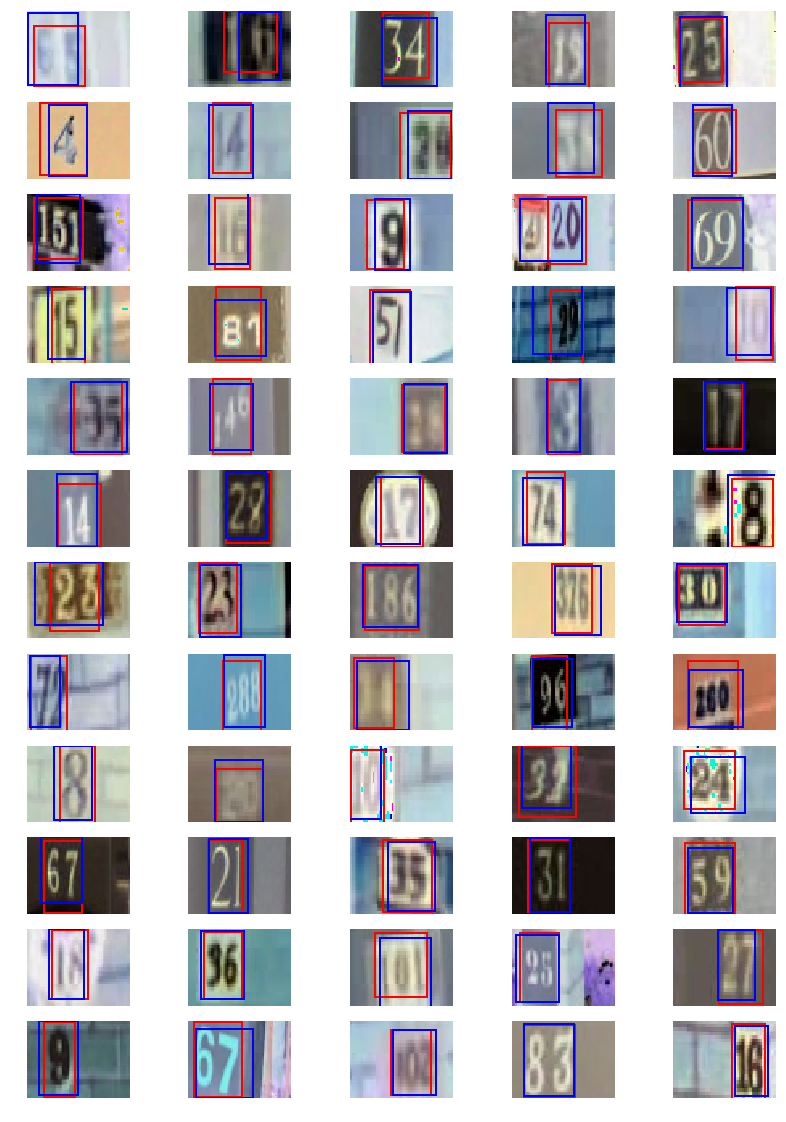

In [74]:
index = 2
display(test_data[index:index+60], test_coordinates[index:index+60], box[index:index+60])

From images below we can see that predicted bounding box is very accurate.

# 6) Convert model into tflite format
---------

Freeze tenseflow model graph.

In [2]:
!freeze_graph --input_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg109/Classification109.pb" \
  --input_checkpoint="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg109/Regression109_7.ckpt" \
  --input_binary=true \
  --output_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg109/frozen.pb" \
  --output_node_names="DIGITS/L1","DIGITS/L2","DIGITS/L3","BOX/box"

2019-07-26 18:08:53.434623: I T:\src\github\tensorflow\tensorflow\core\platform\cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2019-07-26 18:08:54.128729: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 960M major: 5 minor: 0 memoryClockRate(GHz): 1.176
pciBusID: 0000:01:00.0
totalMemory: 4.00GiB freeMemory: 3.35GiB
2019-07-26 18:08:54.129250: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1484] Adding visible gpu devices: 0
2019-07-26 18:08:56.830138: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:965] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-07-26 18:08:56.830457: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:971]      0 
2019-07-26 18:08:56.830665: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_devic

In [2]:
!freeze_graph --input_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81.pb" \
  --input_checkpoint="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81_20.ckpt" \
  --input_binary=true \
  --output_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/frozen.pb" \
  --output_node_names="output/L1","output/L2","output/L3","output/box"

2019-01-02 23:27:47.621254: I T:\src\github\tensorflow\tensorflow\core\platform\cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2019-01-02 23:27:48.221743: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 960M major: 5 minor: 0 memoryClockRate(GHz): 1.176
pciBusID: 0000:01:00.0
totalMemory: 4.00GiB freeMemory: 3.35GiB
2019-01-02 23:27:48.222661: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1484] Adding visible gpu devices: 0
2019-01-02 23:27:49.324713: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:965] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-02 23:27:49.325030: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:971]      0 
2019-01-02 23:27:49.325266: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_devic

In [ ]:
!freeze_graph --input_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81.pb" \
  --input_checkpoint="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81_20.ckpt" \
  --input_binary=true \
  --output_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/frozen.pb" \
  --output_node_names="output/L1","output/L2","output/L3","output/box"

In [2]:
!freeze_graph --input_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81.pb" \
  --input_checkpoint="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/Classification81_20.ckpt" \
  --input_binary=true \
  --output_graph="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/frozen.pb" \
  --output_node_names="output/L1","output/L2","output/L3","output/box"

2019-07-23 10:07:14.787792: I T:\src\github\tensorflow\tensorflow\core\platform\cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2019-07-23 10:07:15.409572: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1405] Found device 0 with properties: 
name: GeForce GTX 960M major: 5 minor: 0 memoryClockRate(GHz): 1.176
pciBusID: 0000:01:00.0
totalMemory: 4.00GiB freeMemory: 3.35GiB
2019-07-23 10:07:15.410090: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1484] Adding visible gpu devices: 0
2019-07-23 10:07:16.464062: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:965] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-07-23 10:07:16.464407: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:971]      0 
2019-07-23 10:07:16.464622: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_devic

Remove dropout in model graph (Tflite don't support dropout op).

In [40]:
from tensorflow.core.framework import graph_pb2
frozen_model_path = os.path.join( "Models","Model_reg12","frozen.pb")
frozen_model_withou_dp_path = os.path.join( "Models","Model_reg12","frozen_model_without_dropout.pb")

graph = tf.GraphDef()
with tf.gfile.Open(frozen_model_path, 'rb') as f:
    data = f.read()
    graph.ParseFromString(data)
            
    #CNN dropouts
    graph.node[67].input[0] = graph.node[54].name
    graph.node[86].input[0] = graph.node[73].name
    graph.node[105].input[0] = graph.node[92].name
    #Fc dropouts
    graph.node[124].input[0] = graph.node[111].name
    graph.node[142].input[0] = graph.node[129].name
    #Outouts
    graph.node[157].input[0] = graph.node[144].name
    graph.node[159].input[0] = graph.node[144].name

    nodes = graph.node[:55] + graph.node[67:74] + graph.node[86:93] + graph.node[105:112] + \
        graph.node[124:130] + graph.node[142:145] + graph.node[157:]
        
    # Save graph
    output_graph = graph_pb2.GraphDef()
    output_graph.node.extend(nodes)
    with tf.gfile.GFile(frozen_model_withou_dp_path, 'w') as f:
        f.write(output_graph.SerializeToString())
        
#55,74,93,112,130,145

In [3]:
from tensorflow.core.framework import graph_pb2
frozen_model_path = os.path.join( "Models","Model_reg81","frozen.pb")
frozen_model_withou_dp_path = os.path.join( "Models","Model_reg81","frozen_model_without_dropout.pb")

graph = tf.GraphDef()
with tf.gfile.Open(frozen_model_path, 'rb') as f:
    data = f.read()
    graph.ParseFromString(data)
            
    #CNN dropouts
    graph.node[75].input[0] = graph.node[62].name
    graph.node[94].input[0] = graph.node[81].name
    graph.node[113].input[0] = graph.node[100].name
    #Fc dropouts
    graph.node[132].input[0] = graph.node[119].name
    graph.node[150].input[0] = graph.node[137].name
    #Outouts
    graph.node[165].input[0] = graph.node[152].name
    graph.node[167].input[0] = graph.node[152].name
    graph.node[169].input[0] = graph.node[152].name
    graph.node[171].input[0] = graph.node[152].name


    nodes = graph.node[:63] + graph.node[75:82] + graph.node[94:101] + graph.node[113:120] + \
        graph.node[132:138] + graph.node[150:153] + graph.node[165:]
        
    # Save graph
    output_graph = graph_pb2.GraphDef()
    output_graph.node.extend(nodes)
    with tf.gfile.GFile(frozen_model_withou_dp_path, 'w') as f:
        f.write(output_graph.SerializeToString())
        
#63,82,101,120,138,153

In [54]:
from tensorflow.core.framework import graph_pb2
frozen_model_path = os.path.join( "Models","Model_reg12","frozen.pb")

In [ ]:
graph = tf.GraphDef()
with tf.gfile.Open(frozen_model_path, 'rb') as f:
    data = f.read()
    graph.ParseFromString(data)

In [40]:
def display_nodes(nodes):
    for i, node in enumerate(nodes):
        print('%d %s %s' % (i, node.name, node.op))
        [print(u'└─── %d ─ %s' % (i, n)) for i, n in enumerate(node.input)]

Optimize graph.

In [4]:
!python -m tensorflow.python.tools.optimize_for_inference \
--input="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/frozen_model_without_dropout.pb" \
--output="C:/Users/Giedrius/Documents/Python/Number interpreter/Models/Model_reg81/opt.pb" \
--frozen_graph=True \
--input_names="X" \
--output_names="output/L1","output/L2","output/L3","output/box" 

C:\Users\Giedrius\AppData\Local\Programs\Python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Convert model into tflite format (not supported in W10 enviroment).

In [ ]:
!toco \
--input_file="media/sf_Model55/opt.pb" \
--input_format=TENSORFLOW_GRAPHDEF \
--output_format=TFLITE \
--inference_type=FLOAT \
--input_type=FLOAT \
--input_arrays=X \
--output_arrays=output/L1,output/L2,output/L3\
--input_shapes=1,54,54,3 \
--output_file="media/sf_Model55/model.tflite"